<a href="https://www.kaggle.com/code/amulyat29/regression-car-price-prediction?scriptVersionId=157636061" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoam-car-price-prediction/sample_submission.csv
/kaggle/input/autoam-car-price-prediction/train.csv
/kaggle/input/autoam-car-price-prediction/test.csv


# Loading Packages 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Exploratory Data Analysis (EDA)

## Loading Data

In [3]:
train_data = pd.read_csv('/kaggle/input/autoam-car-price-prediction/train.csv')
test_data = pd.read_csv('/kaggle/input/autoam-car-price-prediction/test.csv')

## Understanding the structure 

In [4]:
train_data.head(10)

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
5,mercedes-benz,2001,petrol,286293 km,left,blue,sedan,good,1.8,6000
6,nissan,2019,petrol,49000 miles,left,gray,suv,excellent,2.0,23200
7,nissan,2018,petrol,70000 miles,left,silver,suv,excellent,2.5,19800
8,mercedes-benz,2019,petrol,85000 km,left,black,sedan,excellent,2.0,7000
9,hyundai,2021,petrol,58000 miles,left,silver,sedan,crashed,2.0,13900


In [5]:
train_data.shape, test_data.shape

((1642, 10), (411, 10))

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [7]:
train_data.nunique()

model             5
year             32
motor_type        5
running         643
wheel             1
color            17
type              7
status            5
motor_volume     20
price           294
dtype: int64

In [8]:
test_data.nunique()

Id              411
model             5
year             30
motor_type        3
running         270
wheel             2
color            14
type              5
status            5
motor_volume     10
dtype: int64

In [9]:
train_data.describe()

,year,motor_volume,price
count,1642.000000,1642.000000,1642.000000
mean,2014.805725,2.035018,15982.633374
std,6.587573,0.253069,7176.084647
min,1987.000000,0.200000,462.000000
25%,2013.000000,2.000000,12000.000000
50%,2017.000000,2.000000,15750.000000
75%,2019.000000,2.000000,18500.000000
max,2023.000000,4.000000,87000.000000


In [10]:
train_data.isnull().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [11]:
test_data.isnull().sum()

Id              0
model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
dtype: int64

## Univariate Analysis 

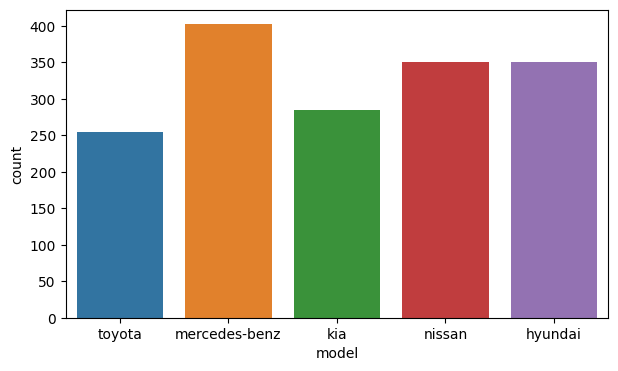

In [12]:
plt.figure(figsize = (7, 4))
sns.countplot(data = train_data, x = 'model')
plt.show()

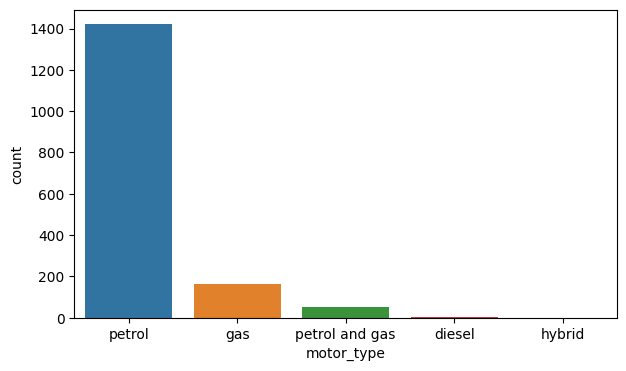

In [13]:
plt.figure(figsize = (7, 4))
sns.countplot(data = train_data, x = 'motor_type')
plt.show()

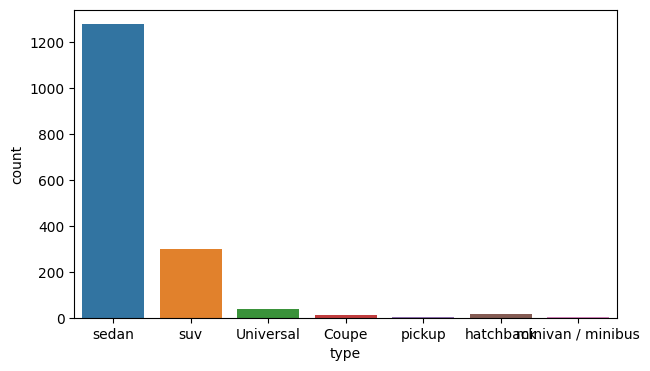

In [14]:
plt.figure(figsize = (7, 4))
sns.countplot(data = train_data, x = 'type')
plt.show()

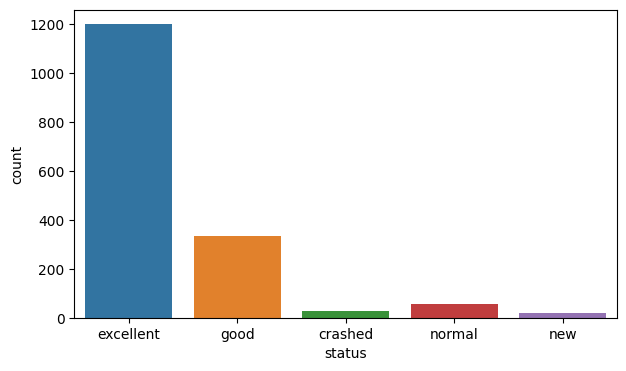

In [15]:
plt.figure(figsize = (7, 4))
sns.countplot(data = train_data, x = 'status')
plt.show()

## Bivariate Analysis 

<Axes: >

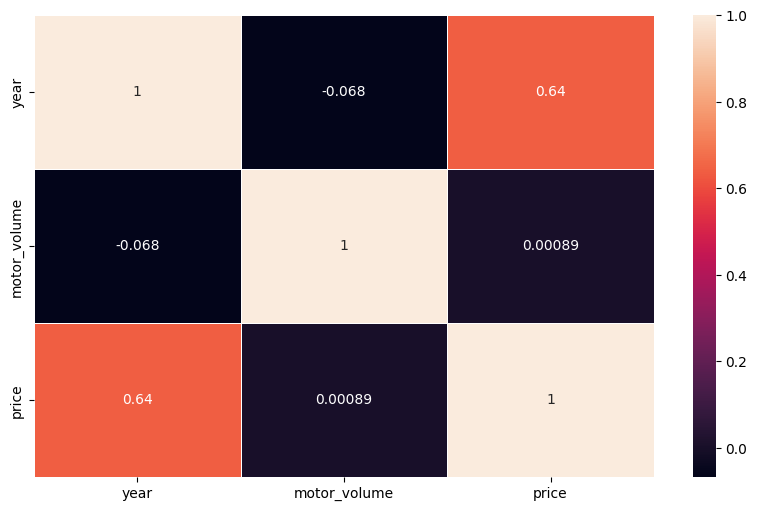

In [16]:
numerical_features = train_data.select_dtypes(exclude = 'object').columns
plt.figure(figsize = (10,6))
sns.heatmap(data = train_data[numerical_features].corr(), annot = True, linewidth = 0.5)

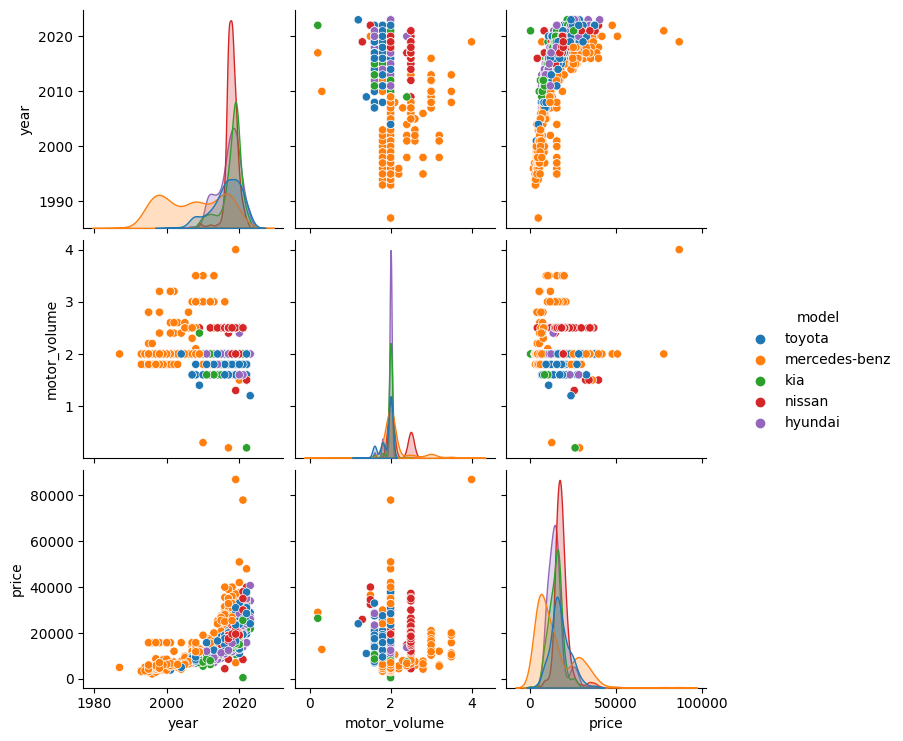

In [17]:
sns.pairplot(data = train_data, hue = 'model')

## Observations
1. We need to convert the running column to numeric. Also make the data consistent by converting into a single metric either miles or km. 
2. There is only 1 wheel type in train_data whereas there are 2 types in test_data.
3. There are no missing values in either train_data or test_data. 
4. There are a few duplicates in the train_data which we removed by keeping the first row and dropping the others.
5. The motor_type of most of the data is of type petrol

# Data Preprocessing

## Converting running column to km

In [18]:
import re

# Function to convert distances to kilometers
def convert_to_km(distance):
    # Extract numerical value and unit using regular expression
    value, unit = re.match(r'(\d+)\s*([a-zA-Z]+)', distance).groups()
    
    # Convert miles to kilometers if the unit is 'miles'
    if unit.lower() == 'miles':
        return float(value) * 1.60934
    else:
        return float(value)

# Apply the conversion function to the 'running' column
train_data['running_km'] = train_data['running'].apply(convert_to_km)
test_data['running_km'] = test_data['running'].apply(convert_to_km)

## Removing duplicates 

In [19]:
train_data.drop_duplicates(inplace = True, keep = 'first')
train_data.shape

(1633, 11)

## Encoding categorical variables

In [20]:
cat_features = ['model', 'motor_type', 'color', 'wheel', 'type', 'status']
encoder = LabelEncoder()
for feature in cat_features:
    train_data[feature] = encoder.fit_transform(train_data[feature])
    test_data[feature] = encoder.fit_transform(test_data[feature])

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 0 to 1641
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1633 non-null   int64  
 1   year          1633 non-null   int64  
 2   motor_type    1633 non-null   int64  
 3   running       1633 non-null   object 
 4   wheel         1633 non-null   int64  
 5   color         1633 non-null   int64  
 6   type          1633 non-null   int64  
 7   status        1633 non-null   int64  
 8   motor_volume  1633 non-null   float64
 9   price         1633 non-null   int64  
 10  running_km    1633 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 153.1+ KB


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            411 non-null    int64  
 1   model         411 non-null    int64  
 2   year          411 non-null    int64  
 3   motor_type    411 non-null    int64  
 4   running       411 non-null    object 
 5   wheel         411 non-null    int64  
 6   color         411 non-null    int64  
 7   type          411 non-null    int64  
 8   status        411 non-null    int64  
 9   motor_volume  411 non-null    float64
 10  running_km    411 non-null    float64
dtypes: float64(2), int64(8), object(1)
memory usage: 35.4+ KB


## Splitting the data into train and validation sets 

In [23]:
X = train_data.drop(['running', 'price'], axis = 1)
y = train_data['price']

## Normalizing the data

In [24]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size =0.2, random_state = 123)
print("Shape of training data: ", X_train.shape, y_train.shape)
print("Shape of validation data", X_val.shape, y_val.shape)

Shape of training data:  (1306, 9) (1306,)
Shape of validation data (327, 9) (327,)


# Modelling Data 

# XGBoost

In [26]:
# Create the model
xgb_model = XGBRegressor()

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val)


In [27]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 19001089.958976917


# Fine tuning XGBoost model

In [28]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [29]:
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.9}


In [30]:

# Make predictions on the test set
y_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 12145822.209317626


# CatBoost 

In [31]:
# Create a CatBoostRegressor
cb_model = CatBoostRegressor(verbose = False, random_state=42)

# Fit the model
cb_model.fit(X_train, y_train)

# Make predictions
y_pred = cb_model.predict(X_val)


In [32]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 13597411.150225159


# Fine tuning CatBoost model

In [33]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [ 4, 5, 6, 8, 9],
    'iterations': [50, 100, 200],
    'l2_leaf_reg': [1, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}

In [34]:
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_val)


Best Hyperparameters: {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.2, 'subsample': 0.9}


In [35]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 12758829.325532777


# Submission

In [36]:
ids = test_data['Id']
test_data.drop(['Id', 'running'], axis = 1, inplace = True)
test_data = scaler.transform(test_data)


In [37]:
# final_model = best_model
xgb_model = XGBRegressor(colsample_bytree = 0.9, learning_rate = 0.1, max_depth= 4, min_child_weight = 5, n_estimators= 50, subsample = 0.9)
cb_model = CatBoostRegressor(verbose = False, depth = 5, iterations = 100, l2_leaf_reg = 5, learning_rate = 0.2, subsample = 0.9, random_state=42)
final_model = xgb_model

In [38]:
final_model.fit(X, y)
predictions = final_model.predict(test_data)


In [39]:
submission=pd.DataFrame({ 'Id' :ids,'price':predictions})
submission.to_csv('submission.csv',index=False)

In [40]:
submission.head()

,Id,price
0,0,16567.701172
1,1,17000.423828
2,2,21583.623047
3,3,14624.866211
4,4,7322.667969
